In [2]:
!python -V

Python 3.9.19


In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [7]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/2', creation_time=1720599927434, experiment_id='2', last_update_time=1720599927434, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [8]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829577

/tmp/ipykernel_2301/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2301/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


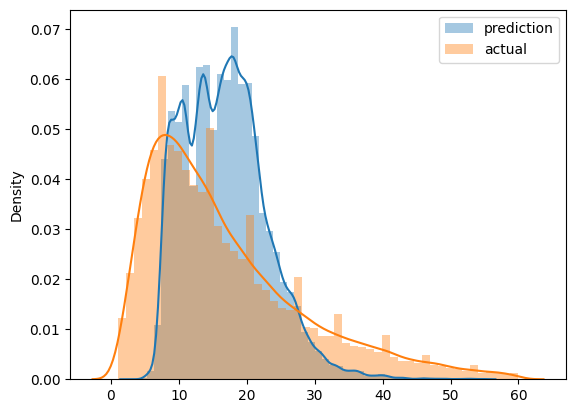

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715209663881

In [18]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [38]:
with mlflow.start_run():

    mlflow.set_tag('developer','farhad')
    
    mlflow.log_param('train-data-path', './data/green_tripdata_2021-01.parquet')
    mlflow.log_param('valid-data-path', './data/green_tripdata_2021-02.parquet')
    
    alpha=0.1
    mlflow.log_param( "alpha", alpha)

    lr=Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred=lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)
    
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [17]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [18]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [19]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [20]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:18:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.98996                          
[1]	validation-rmse:10.00568                          
[2]	validation-rmse:9.22259                           
[3]	validation-rmse:8.60440                           
  0%|          | 0/50 [00:21<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [18]:
import mlflow
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

params={
    'learning_rate' : 0.26166909649561304,
    'max_depth': 51,
    'min_child_weight':1.0160835625117408,
    'objective': 'reg:linear',
    'reg_alpha': 0.049029488858714984,
    'reg_lambda': 0.00411090795122157,
    'seed': 42
}

with mlflow.start_run():
    
    booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:50:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.15928
[1]	validation-rmse:8.80607
[2]	validation-rmse:7.94051
[3]	validation-rmse:7.40526
[4]	validation-rmse:7.07172
[5]	validation-rmse:6.86386
[6]	validation-rmse:6.73199
[7]	validation-rmse:6.64773
[8]	validation-rmse:6.59344
[9]	validation-rmse:6.55417
[10]	validation-rmse:6.52628
[11]	validation-rmse:6.50537
[12]	validation-rmse:6.49133
[13]	validation-rmse:6.47881
[14]	validation-rmse:6.47089
[15]	validation-rmse:6.46487
[16]	validation-rmse:6.46054
[17]	validation-rmse:6.45772
[18]	validation-rmse:6.45508
[19]	validation-rmse:6.45119
[20]	validation-rmse:6.44955
[21]	validation-rmse:6.44694
[22]	validation-rmse:6.44338
[23]	validation-rmse:6.44029
[24]	validation-rmse:6.43798
[25]	validation-rmse:6.43618
[26]	validation-rmse:6.43456
[27]	validation-rmse:6.43219
[28]	validation-rmse:6.42930
[29]	validation-rmse:6.42746
[30]	validation-rmse:6.42549
[31]	validation-rmse:6.42311
[32]	validation-rmse:6.42090
[33]	validation-rmse:6.41850
[34]	validation-rmse:6.

In [40]:
#mlflow.xgboost.autolog()

2024/07/10 15:24:17 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.


In [16]:
import mlflow
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


with mlflow.start_run():

    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params={
        'learning_rate' : 0.26166909649561304,
        'max_depth': 51,
        'min_child_weight':1.0160835625117408,
        'objective': 'reg:linear',
        'reg_alpha': 0.049029488858714984,
        'reg_lambda': 0.00411090795122157,
        'seed': 42
    }

    mlflow.log_params(best_params)
        
    booster = xgb.train(
            params=best_params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50)
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:51:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.15928
[1]	validation-rmse:8.80607
[2]	validation-rmse:7.94051
[3]	validation-rmse:7.40526
[4]	validation-rmse:7.07172
[5]	validation-rmse:6.86386
[6]	validation-rmse:6.73199
[7]	validation-rmse:6.64773
[8]	validation-rmse:6.59344
[9]	validation-rmse:6.55417
[10]	validation-rmse:6.52628
[11]	validation-rmse:6.50537
[12]	validation-rmse:6.49133
[13]	validation-rmse:6.47881
[14]	validation-rmse:6.47089
[15]	validation-rmse:6.46487
[16]	validation-rmse:6.46054
[17]	validation-rmse:6.45772
[18]	validation-rmse:6.45508
[19]	validation-rmse:6.45119
[20]	validation-rmse:6.44955
[21]	validation-rmse:6.44694
[22]	validation-rmse:6.44338
[23]	validation-rmse:6.44029
[24]	validation-rmse:6.43798
[25]	validation-rmse:6.43618
[26]	validation-rmse:6.43456
[27]	validation-rmse:6.43219
[28]	validation-rmse:6.42930
[29]	validation-rmse:6.42746
[30]	validation-rmse:6.42549
[31]	validation-rmse:6.42311
[32]	validation-rmse:6.42090
[33]	validation-rmse:6.41850
[34]	validation-rmse:6.

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:52:42] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [20]:
logged_model = 'runs:/04f7cf0464994033a58f2456e27c6fcd/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 04f7cf0464994033a58f2456e27c6fcd

In [21]:
xgboost_model=mlflow.xgboost.load_model(logged_model)
xgboost_model

In [23]:
y_pred = xgboost_model.predict(valid)
y_pred

array([14.197969 ,  7.1425724, 14.635988 , ..., 13.475773 ,  5.916034 ,
        8.115837 ], dtype=float32)

In [24]:
mlflow.search_experiments()

[<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/3', creation_time=1720632238928, experiment_id='3', last_update_time=1720632238928, lifecycle_stage='active', name='my-cool-experiment', tags={}>,
 <Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/2', creation_time=1720599927434, experiment_id='2', last_update_time=1720599927434, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1720599806039, experiment_id='0', last_update_time=1720599806039, lifecycle_stage='active', name='Default', tags={}>]

In [17]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI= "sqlite:///mlflow.db"

client=MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [18]:
client.list_experiments()

AttributeError: 'MlflowClient' object has no attribute 'list_experiments'

In [19]:
client.create_experiment(name="my-cool-experiment")

MlflowException: Experiment(name=my-cool-experiment) already exists. Error: (raised as a result of Query-invoked autoflush; consider using a session.no_autoflush block if this flush is occurring prematurely)
(sqlite3.IntegrityError) UNIQUE constraint failed: experiments.name
[SQL: INSERT INTO experiments (name, artifact_location, lifecycle_stage, creation_time, last_update_time) VALUES (?, ?, ?, ?, ?)]
[parameters: ('my-cool-experiment', None, 'active', 1720635571802, 1720635571802)]
(Background on this error at: https://sqlalche.me/e/20/gkpj)

In [27]:
from mlflow.entities import ViewType
runs=client.search_runs(
    experiment_ids="2",
    filter_string="metrics.rmse < 6.8",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]


)

In [28]:
for run in runs:
    print(f"run_id: {run.info.run_id}, rmse:{run.data.metrics['rmse']:.4f}")

run_id: e22bf57054df4742bfb7a9025b6e3813, rmse:6.3176
run_id: 04f7cf0464994033a58f2456e27c6fcd, rmse:6.3176
run_id: c95280260c5c450bb1c019094c4b4e32, rmse:6.3176
run_id: ef56bca62cf4444a8c5c0a15329f6e72, rmse:6.3176
run_id: f8a650414ae24c69b5858f2286ead4c5, rmse:6.3176


In [29]:
import mlflow

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [30]:
run_id="e22bf57054df4742bfb7a9025b6e3813"
model_uri=f"runs:/{run_id}/model"
mlflow.register_model(model_uri=model_uri, name ="nyc")

Registered model 'nyc' already exists. Creating a new version of this model...
Created version '2' of model 'nyc'.


<ModelVersion: aliases=[], creation_timestamp=1720638083488, current_stage='None', description=None, last_updated_timestamp=1720638083488, name='nyc', run_id='e22bf57054df4742bfb7a9025b6e3813', run_link=None, source='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/2/e22bf57054df4742bfb7a9025b6e3813/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [31]:
model_uri

'runs:/e22bf57054df4742bfb7a9025b6e3813/model'

In [32]:
model_name = "nyc"
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 2, stage: None


/tmp/ipykernel_2301/2579723887.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_versions = client.get_latest_versions(name=model_name)
